# Data Visualization and Metrics on the CelebA_HQ Dataset

In [30]:
import pandas as pd
import sklearn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Populate Dataframes

Each dataframe consists of 5 columns: `image`, `image_path`, `actual_label`, `predicted_label`, `confidence`
* `image` is the image name, for example 10.jpg
* `image_path` is the path to the image
* `actual_label` is the actual label for that person (the original image)
* `predicted_label` is the result of running the original, attacked, or defended image into the classifier. This is the label used to determine if the attack or defense was effective.
* `confidence` is the confidence in which we think that the image belongs to that class. This is the max value of the prediction.

In [31]:
fgsm05_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/FGSM05.csv")
fgsm05_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM05.csv")
fgsm05_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM05-detected.csv")

fgsm10_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/FGSM10.csv")
fgsm10_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10.csv")
fgsm10_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-detected.csv")

fgsm15_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/FGSM15.csv")
fgsm15_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM15.csv")
fgsm15_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM15-detected.csv")

fgsm20_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/FGSM20.csv")
fgsm20_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM20.csv")
fgsm20_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM20-detected.csv")

fgsm25_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/FGSM25.csv")
fgsm25_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM25.csv")
fgsm25_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM25-detected.csv")

fgsm50_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/FGSM50.csv")
fgsm50_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM50.csv")
fgsm50_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM50-detected.csv")

fgsm75_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/FGSM75.csv")
fgsm75_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM75.csv")
fgsm75_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM75-detected.csv")

fgsm90_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/FGSM90.csv")
fgsm90_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM90.csv")
fgsm90_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM90-detected.csv")

pgd1010_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/PGD1010.csv")
pgd1010_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-PGD1010.csv")
pgd1010_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-PGD1010-detected.csv")

pgd2010_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/PGD2010.csv")
pgd2010_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-PGD2010.csv")
pgd2010_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-PGD2010-detected.csv")

pgd2020_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/PGD2020.csv")
pgd2020_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-PGD2020.csv")
pgd2020_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-PGD2020-detected.csv")

pgd5050_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/PGD5050.csv")
pgd5050_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-PGD5050.csv")
pgd5050_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-PGD5050-detected.csv")

# jitter1010_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/Jitter1010.csv")
# jitter1010_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-Jitter1010.csv")
# jitter1010_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-Jitter1010-detected.csv")

test_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/test.csv")
test_defended_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-test.csv")
test_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-test-detected.csv")

## Defense Metrics

In [32]:
def print_test_metrics(test_df, test_defended_df, test_detected_df):
   test_defended_df["predicted_label_test"] = test_df["predicted_label"]
   
   face_detection = pd.merge(test_detected_df, test_defended_df, on=['image'], how='inner').drop(columns=['Unnamed: 0_x', 'image_path_x', 'Unnamed: 0_y', 'image_path_y',
   'actual_label', 'predicted_label', 'confidence'])

   defense_df = pd.merge(test_detected_df, test_defended_df, on=['image'], how='outer')
   defense_df = defense_df[defense_df.isna().any(axis=1)].drop(columns=['Unnamed: 0_x', 'image_path_x', 'Unnamed: 0_y'])
   defense_df = defense_df.rename(columns={'image_path_y': 'image_path'})

   accuracy_orig_df = test_df[test_df["actual_label"] == test_df["predicted_label"]]   
   accuracy_df = defense_df[defense_df["predicted_label_test"] == defense_df["predicted_label"]]
   
   total_images = len(test_df)
   total_defendable_images = len(defense_df)

   accuracy = len(accuracy_df) / total_defendable_images * 100
   accuracy_orig = len(accuracy_orig_df) / total_images * 100
   # accuracy on classifier
   # print(f"Accuracy of classifier on original test set {accuracy_orig:.2f}%")
   # A = C
   print(f"Accuracy on StyleCLIP-test {accuracy:.2f}%")


   # img 19 = acutal_label: 5
   # classifier(img 19) = predicted_label : 20

   # classifier(styleClIP(img 19)) = predicted_label : 20
   # compare(styleCLIP(img 19), predicted_label)
   # - does 20 = 20? 

In [108]:
print_test_metrics(test_df, test_defended_df, test_detected_df)

Accuracy of classifier on original test set 81.41%
Accuracy on StyleCLIP-test 68.53%


### Defense Metrics

In [113]:
def print_defense_metrics(attackname, attack_df, defense_df, detected_df, test_df=test_df, test_defended_df=test_defended_df, use_predicted=True):
      '''
      Dataframe Calculations.
      '''
      attacks_merged = pd.merge(test_df, attack_df, on=["image"], how="inner").drop(columns=['Unnamed: 0_x', 'image_path_x', 'actual_label_x',
       'confidence_x', 'Unnamed: 0_y', 'image_path_y',
       'actual_label_y', 'confidence_y'])
      attacks_merged = attacks_merged.rename(columns={'predicted_label_x': 'predicted_label_testdf', 'predicted_label_y': 'predicted_label_attackdf'})
      succ_attacks = attacks_merged[attacks_merged["predicted_label_testdf"] != attacks_merged["predicted_label_attackdf"]]
      
      defense_merged = pd.merge(succ_attacks, defense_df, on=["image"], how="inner").drop(columns=['Unnamed: 0',
       'image_path', 'actual_label', 'confidence'])
      defense_merged = defense_merged.rename(columns={'predicted_label': 'predicted_label_defensedf'})
      succ_sanitization = defense_merged[defense_merged["predicted_label_testdf"] == defense_merged["predicted_label_defensedf"]]
      succ_class_change = defense_merged[defense_merged["predicted_label_attackdf"] != defense_merged["predicted_label_defensedf"]]
      
      detected_merged = pd.merge(succ_attacks, detected_df, on=["image"], how="inner")
      
      # don't double count examples from detected face and class change.
      detected_class_change_merged = pd.merge(detected_merged, succ_class_change, on=["image"], how="inner")

      '''
      Accuracy Metrics.
      '''
      attack_eff = (succ_attacks.shape[0]/len(attack_df)) * 100
      detection_eff = (detected_merged.shape[0]/len(succ_attacks)) * 100
      succ_class_change_eff = (succ_class_change.shape[0]/len(succ_attacks)) * 100
      sanitization_eff = (succ_sanitization.shape[0]/len(succ_attacks)) * 100
      double_count = (detected_class_change_merged.shape[0]/len(succ_attacks)) * 100
      overall = succ_class_change_eff + detection_eff - double_count
      overall_numerator = succ_class_change.shape[0] + detected_merged.shape[0] - detected_class_change_merged.shape[0]

      print("-" * 50)
      print(f"RUNNING {attackname} DEFENSE METRICS...\n")
      print(f"Attack Effectiveness: {attack_eff:.2f}% ({succ_attacks.shape[0]}/{len(attack_df)})")
      print()
      print(f"Face Detection Effectiveness: {detection_eff:.2f}% ({detected_merged.shape[0]}/{len(succ_attacks)})")
      print(f"Adversarial Classification Change Effectiveness: {succ_class_change_eff:.2f}% ({succ_class_change.shape[0]}/{len(succ_attacks)})")
      print(f"\tSanitization Effectiveness: {sanitization_eff:.2f}% ({succ_sanitization.shape[0]}/{len(succ_attacks)})")
      print()
      print(f"Examples in Both Defenses: {double_count:.2f}% ({detected_class_change_merged.shape[0]}/{len(succ_attacks)})")
      print()
      print(f"Overall Effectiveness (single-count): {overall:.2f}% ({overall_numerator}/{len(succ_attacks)})")

      return overall, attack_eff, {"class_change": succ_class_change_eff, "sanitization": sanitization_eff, "face_det" : detection_eff}

In [114]:
fgsm05_def_eff, fgsm05_att_eff, fgsm05defense = print_defense_metrics("FGSM05", fgsm05_attack_df, fgsm05_defend_df, fgsm05_detected_df)
fgsm10_def_eff, fgsm10_att_eff, fgsm10defense = print_defense_metrics("FGSM10", fgsm10_attack_df, fgsm10_defend_df, fgsm10_detected_df)
fgsm15_def_eff, fgsm15_att_eff, fgsm15defense = print_defense_metrics("FGSM15", fgsm15_attack_df, fgsm15_defend_df, fgsm15_detected_df)
fgsm20_def_eff, fgsm20_att_eff, fgsm20defense = print_defense_metrics("FGSM20", fgsm20_attack_df, fgsm20_defend_df, fgsm20_detected_df)
fgsm25_def_eff, fgsm25_att_eff, fgsm25defense = print_defense_metrics("FGSM25", fgsm25_attack_df, fgsm25_defend_df, fgsm25_detected_df)
fgsm50_def_eff, fgsm50_att_eff, fgsm50defense = print_defense_metrics("FGSM50", fgsm50_attack_df, fgsm50_defend_df, fgsm50_detected_df)
fgsm75_def_eff, fgsm75_att_eff, fgsm75defense = print_defense_metrics("FGSM75", fgsm75_attack_df, fgsm75_defend_df, fgsm75_detected_df)
fgsm90_def_eff, fgsm90_att_eff, fgsm90defense = print_defense_metrics("FGSM90", fgsm90_attack_df, fgsm90_defend_df, fgsm90_detected_df)

pgd1010_def_eff, pgd1010_att_eff, _ = print_defense_metrics("PGD1010", pgd1010_attack_df, pgd1010_defend_df, pgd1010_detected_df)
pgd2010_def_eff, pgd2010_att_eff, _ =print_defense_metrics("PGD2010", pgd2010_attack_df, pgd2010_defend_df, pgd2010_detected_df)
pgd2020_def_eff, pgd2020_att_eff, _ =print_defense_metrics("PGD2020", pgd2020_attack_df, pgd2020_defend_df, pgd2020_detected_df)
pgd5050_def_eff, pgd5050_att_eff, _ =print_defense_metrics("PGD5050", pgd5050_attack_df, pgd5050_defend_df, pgd5050_detected_df)

# jitter1010_def_eff, jitter1010_att_eff = print_defense_metrics("Jitter1010", jitter1010_attack_df, jitter1010_defend_df, jitter1010_detected_df)

--------------------------------------------------
RUNNING FGSM05 DEFENSE METRICS...

Attack Effectiveness: 19.10% (38/199)

Face Detection Effectiveness: 0.00% (0/38)
Adversarial Classification Change Effectiveness: 55.26% (21/38)
	Sanitization Effectiveness: 10.53% (4/38)

Examples in Both Defenses: 0.00% (0/38)

Overall Effectiveness (single-count): 55.26% (21/38)
--------------------------------------------------
RUNNING FGSM10 DEFENSE METRICS...

Attack Effectiveness: 44.72% (89/199)

Face Detection Effectiveness: 2.25% (2/89)
Adversarial Classification Change Effectiveness: 49.44% (44/89)
	Sanitization Effectiveness: 6.74% (6/89)

Examples in Both Defenses: 0.00% (0/89)

Overall Effectiveness (single-count): 51.69% (46/89)
--------------------------------------------------
RUNNING FGSM15 DEFENSE METRICS...

Attack Effectiveness: 68.84% (137/199)

Face Detection Effectiveness: 1.46% (2/137)
Adversarial Classification Change Effectiveness: 52.55% (72/137)
	Sanitization Effectivenes

### Defense Visualizations

/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

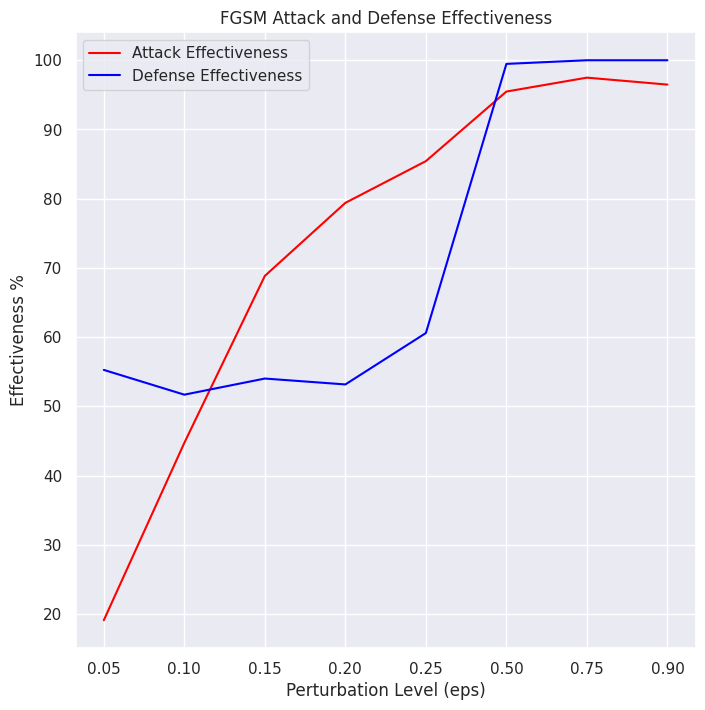

In [103]:
# Sample data
x = ["0.05", "0.10", "0.15", "0.20", "0.25", "0.50", "0.75", "0.90"]
y1 = [fgsm05_att_eff, fgsm10_att_eff, fgsm15_att_eff, fgsm20_att_eff, fgsm25_att_eff, fgsm50_att_eff, fgsm75_att_eff, fgsm90_att_eff]
y2 = [fgsm05_def_eff, fgsm10_def_eff, fgsm15_def_eff, fgsm20_def_eff, fgsm25_def_eff, fgsm50_def_eff, fgsm75_def_eff, fgsm90_def_eff]

df = pd.DataFrame({'X': x, 'Line 1': y1, 'Line 2': y2})
plt.figure(figsize=(8,8))
# Use Seaborn to plot the lines
sns.set(style="darkgrid")
sns.lineplot(x='X', y='Line 1', data=df, c="red", label='Attack Effectiveness')
sns.lineplot(x='X', y='Line 2', data=df, c="blue", label='Defense Effectiveness')

# Show the plot
plt.title("FGSM Attack and Defense Effectiveness")
plt.xlabel("Perturbation Level (eps)")
plt.ylabel("Effectiveness %")
plt.legend()
plt.show()

/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

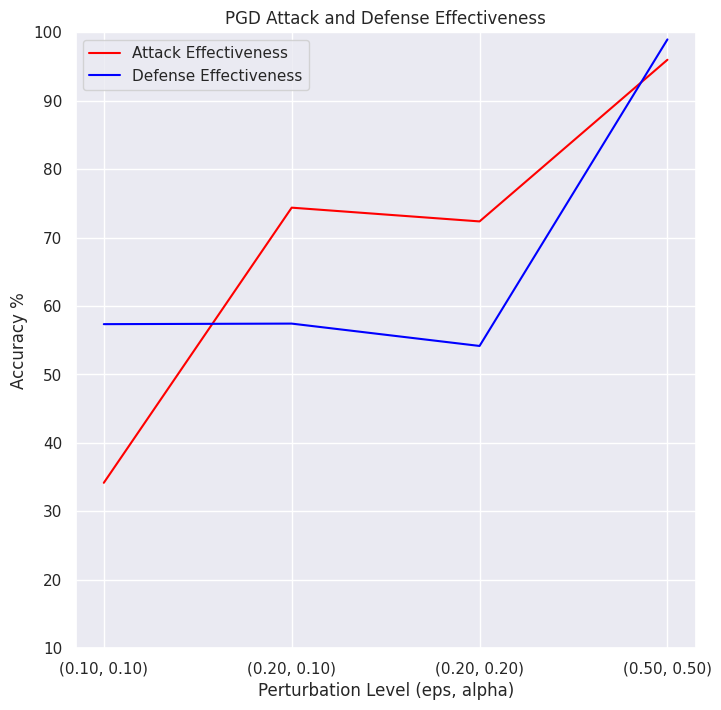

In [104]:
# Sample data
x = ["(0.10, 0.10)", "(0.20, 0.10)", "(0.20, 0.20)", "(0.50, 0.50)"]
y1 = [pgd1010_att_eff, pgd2010_att_eff, pgd2020_att_eff, pgd5050_att_eff]
y2 = [pgd1010_def_eff, pgd2010_def_eff, pgd2020_def_eff, pgd5050_def_eff]

df = pd.DataFrame({'X': x, 'Line 1': y1, 'Line 2': y2})
plt.figure(figsize=(8,8))
# Use Seaborn to plot the lines
sns.set(style="darkgrid")
sns.lineplot(x='X', y='Line 1', data=df, c="red", label='Attack Effectiveness')
sns.lineplot(x='X', y='Line 2', data=df, c="blue", label='Defense Effectiveness')

# Show the plot
plt.title("PGD Attack and Defense Effectiveness")
plt.xlabel("Perturbation Level (eps, alpha)")
plt.ylabel("Accuracy %")
plt.ylim(10, 100)
plt.legend()
plt.show()

### Different Prompts on Same Alpha Beta Values

--------------------------------------------------
RUNNING FGSM10_P1 DEFENSE METRICS...

Attack Effectiveness: 44.72% (89/199)

Face Detection Effectiveness: 2.25% (2/89)
Adversarial Classification Change Effectiveness: 48.31% (43/89)
	Sanitization Effectiveness: 7.87% (7/89)

Examples in Both Defenses: 0.00% (0/89)

Overall Effectiveness (single-count): 50.56% (45/89)
--------------------------------------------------
RUNNING FGSM10_P2 DEFENSE METRICS...

Attack Effectiveness: 44.72% (89/199)

Face Detection Effectiveness: 2.25% (2/89)
Adversarial Classification Change Effectiveness: 50.56% (45/89)
	Sanitization Effectiveness: 6.74% (6/89)

Examples in Both Defenses: 0.00% (0/89)

Overall Effectiveness (single-count): 52.81% (47/89)
--------------------------------------------------
RUNNING FGSM10_P3 DEFENSE METRICS...

Attack Effectiveness: 44.72% (89/199)

Face Detection Effectiveness: 2.25% (2/89)
Adversarial Classification Change Effectiveness: 48.31% (43/89)
	Sanitization Effecti

/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


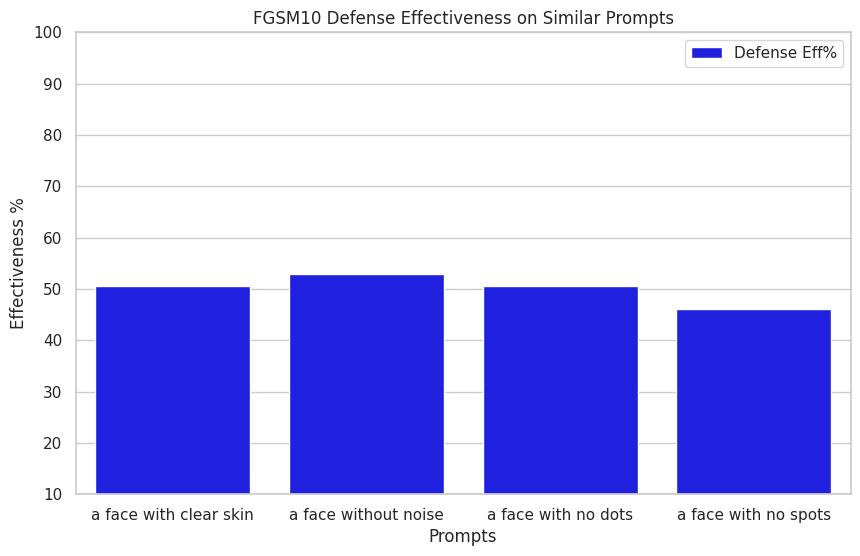

In [105]:
# Sample data

fgsm10_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/FGSM10.csv")
fgsm10_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-detected.csv")

fgsm10_defend_df_p1 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-p1.csv")
fgsm10_defend_df_p2 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-p2.csv")
fgsm10_defend_df_p3 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-p3.csv")
fgsm10_defend_df_p4 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-p4.csv")

p1_def, p1_att, _ = print_defense_metrics("FGSM10_P1", fgsm10_attack_df, fgsm10_defend_df_p1, fgsm10_detected_df)
p2_def, p2_att, _ = print_defense_metrics("FGSM10_P2", fgsm10_attack_df, fgsm10_defend_df_p2, fgsm10_detected_df)
p3_def, p3_att, _ = print_defense_metrics("FGSM10_P3", fgsm10_attack_df, fgsm10_defend_df_p3, fgsm10_detected_df)
p4_def, p4_att, _ = print_defense_metrics("FGSM10_P4", fgsm10_attack_df, fgsm10_defend_df_p4, fgsm10_detected_df)

data = {
    'Category': ['a face with clear skin', 'a face without noise', 'a face with no dots', 'a face with no spots'],
    'Defense Eff%': [p1_def, p2_def, p3_def, p4_def],
}

df = pd.DataFrame(data)

# Set the seaborn style
sns.set(style="whitegrid")

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Defense Eff%', data=df, color='blue', label='Defense Eff%')
plt.legend()
plt.ylim(0, 100)

# Set plot labels and title
plt.xlabel('Prompts')
plt.ylabel('Effectiveness %')
plt.ylim(10, 100)
plt.title('FGSM10 Defense Effectiveness on Similar Prompts')

# Show the plot
plt.show()

### Same Prompt on Different Alpha Beta Values

--------------------------------------------------
RUNNING FGSM10_AB1 DEFENSE METRICS...

Attack Effectiveness: 44.72% (89/199)

Face Detection Effectiveness: 2.25% (2/89)
Adversarial Classification Change Effectiveness: 49.44% (44/89)
	Sanitization Effectiveness: 6.74% (6/89)

Examples in Both Defenses: 0.00% (0/89)

Overall Effectiveness (single-count): 51.69% (46/89)
--------------------------------------------------
RUNNING FGSM10_AB2 DEFENSE METRICS...

Attack Effectiveness: 44.72% (89/199)

Face Detection Effectiveness: 2.25% (2/89)
Adversarial Classification Change Effectiveness: 50.56% (45/89)
	Sanitization Effectiveness: 6.74% (6/89)

Examples in Both Defenses: 0.00% (0/89)

Overall Effectiveness (single-count): 52.81% (47/89)
--------------------------------------------------
RUNNING FGSM10_AB3 DEFENSE METRICS...

Attack Effectiveness: 44.72% (89/199)

Face Detection Effectiveness: 2.25% (2/89)
Adversarial Classification Change Effectiveness: 95.51% (85/89)
	Sanitization Effe

/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


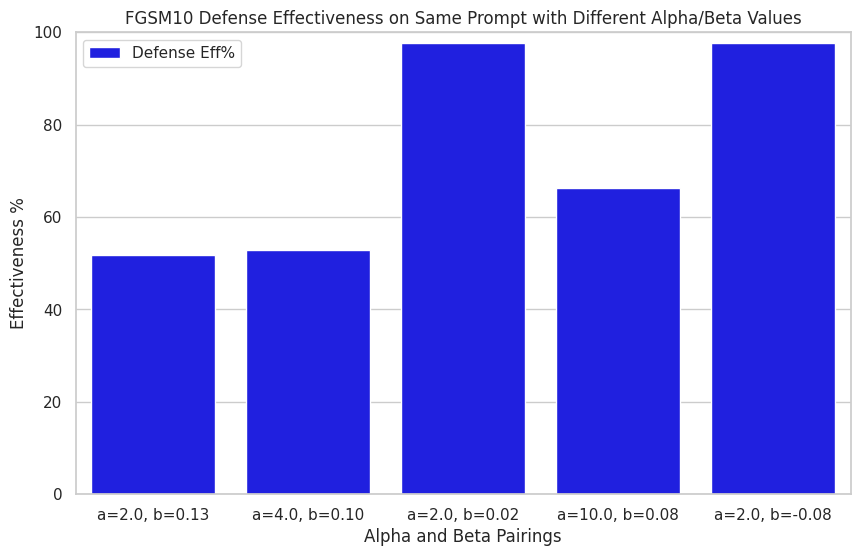

In [107]:
fgsm10_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/FGSM10.csv")
fgsm10_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-detected.csv")

fgsm10_defend_df_ab1 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-ab1.csv")
test_defended_df_ab1 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-test-ab1.csv")
fgsm10_defend_df_ab2 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-ab2.csv")
test_defended_df_ab2 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-test-ab2.csv")
fgsm10_defend_df_ab3 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-ab3.csv")
test_defended_df_ab3 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-test-ab3.csv")
fgsm10_defend_df_ab4 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-ab4.csv")
test_defended_df_ab4 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-test-ab4.csv")
fgsm10_defend_df_ab5 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-ab5.csv")
test_defended_df_ab5 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-test-ab5.csv")

ab1_def, ab1_att, ab1 = print_defense_metrics("FGSM10_AB1", fgsm10_attack_df, fgsm10_defend_df_ab1, fgsm10_detected_df, test_defended_df=test_defended_df_ab1)
ab2_def, ab2_att, ab2 = print_defense_metrics("FGSM10_AB2", fgsm10_attack_df, fgsm10_defend_df_ab2, fgsm10_detected_df, test_defended_df=test_defended_df_ab2)
ab3_def, ab3_att, ab3 = print_defense_metrics("FGSM10_AB3", fgsm10_attack_df, fgsm10_defend_df_ab3, fgsm10_detected_df, test_defended_df=test_defended_df_ab3)
ab4_def, ab4_att, ab4 = print_defense_metrics("FGSM10_AB4", fgsm10_attack_df, fgsm10_defend_df_ab4, fgsm10_detected_df, test_defended_df=test_defended_df_ab4)
ab5_def, ab5_att, ab5 = print_defense_metrics("FGSM10_AB5", fgsm10_attack_df, fgsm10_defend_df_ab5, fgsm10_detected_df, test_defended_df=test_defended_df_ab5)

# Sample data
data = {
    'Category': ['a=2.0, b=0.13', 'a=4.0, b=0.10', 'a=2.0, b=0.02', 'a=10.0, b=0.08', 'a=2.0, b=-0.08'],
    'Defense Eff%': [ab1_def, ab2_def, ab3_def, ab4_def, ab5_def]
}

df = pd.DataFrame(data)

# Set the seaborn style
sns.set(style="whitegrid")

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Defense Eff%', data=df, color='blue', label='Defense Eff%')
plt.legend()
plt.ylim(0, 100)

# Set plot labels and title
plt.xlabel('Alpha and Beta Pairings')
plt.ylabel('Effectiveness %')
plt.title('FGSM10 Defense Effectiveness on Same Prompt with Different Alpha/Beta Values')
# Show the plot
plt.show()

In [110]:
print_test_metrics(test_df, test_defended_df_ab1, test_detected_df)
print_test_metrics(test_df, test_defended_df_ab2, test_detected_df)
print_test_metrics(test_df, test_defended_df_ab3, test_detected_df)
print_test_metrics(test_df, test_defended_df_ab4, test_detected_df)
print_test_metrics(test_df, test_defended_df_ab5, test_detected_df)

Accuracy of classifier on original test set 81.41%
Accuracy on StyleCLIP-test 67.51%
Accuracy of classifier on original test set 81.41%
Accuracy on StyleCLIP-test 68.02%
Accuracy of classifier on original test set 81.41%
Accuracy on StyleCLIP-test 19.80%
Accuracy of classifier on original test set 81.41%
Accuracy on StyleCLIP-test 35.53%
Accuracy of classifier on original test set 81.41%
Accuracy on StyleCLIP-test 18.27%
